## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

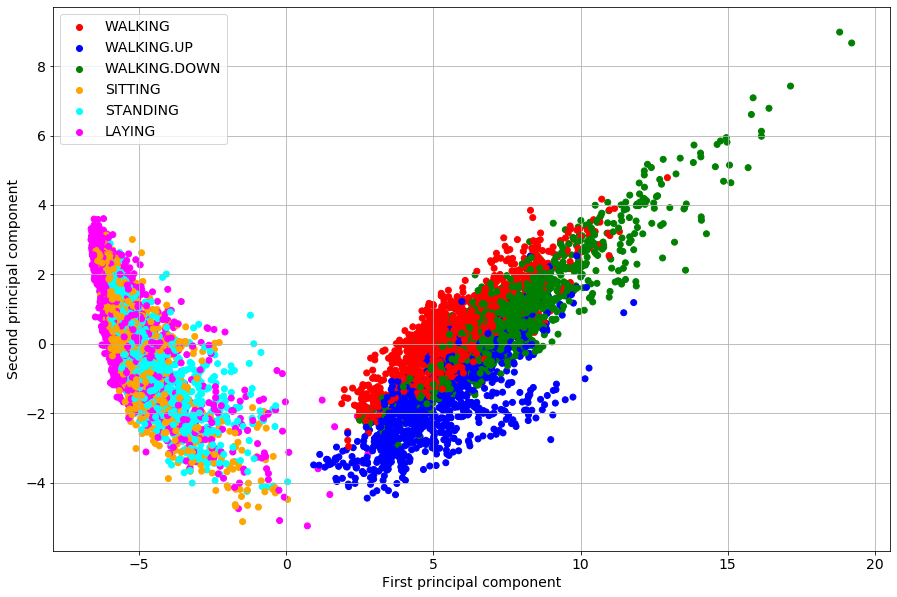

In [3]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()
print()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [4]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [5]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

In [6]:
# Your experiments here
def encode_labels(y):
    y_encoded = np.zeros((y.squeeze(1).size, y.squeeze(1).max()+1))
    y_encoded[np.arange(y.squeeze(1).size), y.squeeze(1)] = 1
    return y_encoded

y_test_encoded = encode_labels(y_test)
y_train_encoded = encode_labels(y_train)
print(y_train_encoded.shape)

(7352, 6)


In [7]:
import torch
import torch.nn as nn

class SimpleConvNet(nn.Module):
    def __init__(self, in_channels=9, out_features=6):
        super(self.__class__, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=9, out_channels=18, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, dilation=1),
            nn.Conv1d(in_channels=18, out_channels=36, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, dilation=1),
            nn.Conv1d(in_channels=36, out_channels=72, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, dilation=1),
            nn.Conv1d(in_channels=72, out_channels=144, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, dilation=1)
        )
        
        self.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(8*144, 6)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [8]:
from torch.utils.data import DataLoader, TensorDataset

train_data = TensorDataset(torch.tensor(X_train).transpose(1, 2), torch.tensor(y_train.squeeze(1)).type(torch.LongTensor))
test_data = TensorDataset(torch.tensor(X_test).transpose(1, 2), torch.tensor(y_test.squeeze(1)).type(torch.LongTensor))

train_loader = DataLoader(train_data, batch_size=16, num_workers=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, num_workers=4)

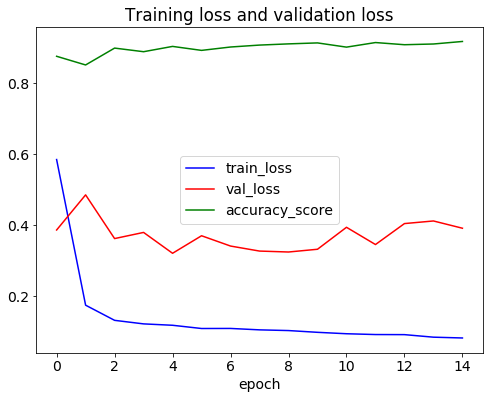

Current train loss: 0.082488
Current val loss: 0.391565
Current accuracy: 0.917543


In [9]:
import matplotlib.pyplot as plt
from IPython import display
from torch.optim import Adam


device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimpleConvNet().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)

BATCH_SIZE = 16
# Your experiments, training and validation loops here
train_loss = []
test_loss = []
accuracy_scores = []
total = 0
correct = 0
for i in range(1, 16):
    model.train()
    running_loss = 0.0
    for j, batch in enumerate(train_loader):
        data, target = batch  
        data, target = data.to(device), target.to(device)
        opt.zero_grad()
        output = model(data)
        predictions = output.argmax(dim=1, keepdim=True).squeeze()
        loss = loss_func(output, target)
        
        loss.backward()
        opt.step()
        running_loss += loss.item()

    train_loss.append(running_loss / len(train_loader))
    model.eval()
    cur_loss = 0.0
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs.data, dim=1)
        cur_loss += loss_func(outputs, labels)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()
    accuracy = correct / total
    accuracy_scores.append(accuracy)
        
    test_loss.append(cur_loss / len(test_loader))
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss and validation loss")
    plt.xlabel("epoch")
    plt.plot(train_loss, 'b', label='train_loss')
    plt.plot(test_loss, 'r', label='val_loss')
    plt.plot(accuracy_scores, color = 'green', label = 'accuracy_score')
    plt.legend()
    plt.show()
    
    print('Current train loss: %f' % (running_loss / len(train_loader)))   
    print('Current val loss: %f' % (cur_loss / len(test_loader)))
    print('Current accuracy: %f' % accuracy)
    scheduler.step()

In [10]:
total = 0
correct = 0
model.eval()
#model = model.to(device)
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()

print('Accuracy == {} %'.format(100 * correct / total))

Accuracy == 91.75432643366135 %


## Отчет.

Я решил попробовать обучить для этой задачи сверточную нейронную сеть, т.к. это был один из подходов, предлагавшихся для решения этой задачи. Эта нейронная сеть должна уметь обрабатывать 1D input, т.к. после препроцессинга данных они имеют вид (batch, seq_len, n_channels). Поэтому архитектура состоит из слоев Conv1D и MaxPool1D, которые выполняют те же функции, что и слои Conv2D и MaxPool2D для изображений. После каждого блока из Conv1D, MaxPool1D, ReLU количество шагов во временном ряду (seq_len) уменьшается в 2 раза, а количество каналов увеличивается в 2 раза. Затем, как и обычно, аутпут сверточной части сетки распрямляется в вектор и передается в полносвязную часть.

Сначала я думал, что для обучения нужно сделать one-hot encoding для y_test и y_train, но nn.CrossEntropyLoss() принимает на вход только 1D вектор в качестве меток. Из-за этого возникала ошибка при обучении, поэтому когда я убрал one-hot encoding, все сразу заработало. В итоге, за 15 эпох сетка обучилась на 91.75% accuracy.